In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt 

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.utils.np_utils import to_categorical
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,GlobalAveragePooling2D,Input,Activation
from keras.layers.merge import add
from keras.optimizers import RMSprop
from keras.activations import relu,softmax
from keras import optimizers,applications,regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras import backend
from keras.models import model_from_json

seed = 42
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [27]:
%autosave 0

Autosave disabled


In [6]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [7]:
#X_train = df_train.drop(['label'], axis=1)
#y_train = df_train['label']

#df_train['label'] = df_train['label'].replace(to_replace=np.nan, value=0.0)
#df_train['label'] = df_train['label'].replace(to_replace='', value=0.0)
y_train_ = df_train['label'].values.astype(np.int).reshape(-1, 1)
X_train = df_train[df_train.columns[1:]].values.astype(np.float32).reshape((-1, 28, 28, 1))

del df_train
X_test = df_test.values.astype(np.float32).reshape((-1, 28, 28, 1))

del df_test

print('Shape of X_train:', X_train.shape)
#print('Shape of y_train:', y_train.shape)
print('Shape of X_test :', X_test.shape)

Shape of X_train: (42000, 28, 28, 1)
Shape of X_test : (28000, 28, 28, 1)


In [ ]:
#X_train = X_train / 255
#X_test = X_test / 255

In [9]:
#X_train = X_train.values.reshape(-1,28,28,1) 
#X_test = X_test.values.reshape(-1,28,28,1)

print('Shape of X_train:', X_train.shape)
print('Shape of X_test :', X_test.shape)

Shape of X_train: (42000, 28, 28, 1)
Shape of X_test : (28000, 28, 28, 1)


In [10]:
# Encoding

y_train = OneHotEncoder(sparse=False).fit_transform(y_train_)
#y_train = to_categorical(y_train, num_classes = 10)
y_train.shape

(42000, 10)

In [12]:
X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train_)

In [13]:
def block(n_output, upscale=False):
    # n_output: number of feature maps in the block
    # upscale: should we use the 1x1 conv2d mapping for shortcut or not
    
    # keras functional api: return the function of type
    # Tensor -> Tensor
    def f(x):
        
        # H_l(x):
        # first pre-activation
        h = BatchNormalization()(x)
        h = Activation(relu)(h)
        # first convolution
        h = Conv2D(kernel_size=3, filters=n_output, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01))(h)
        
        # second pre-activation
        h = BatchNormalization()(x)
        h = Activation(relu)(h)
        # second convolution
        h = Conv2D(kernel_size=3, filters=n_output, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01))(h)
        
        # f(x):
        if upscale:
            # 1x1 conv2d
            f = Conv2D(kernel_size=1, filters=n_output, strides=1, padding='same')(x)
        else:
            # identity
            f = x
        
        # F_l(x) = f(x) + H_l(x):
        return add([f, h])
    
    return f

In [14]:
# input tensor is the 28x28 grayscale image
input_tensor = Input((28, 28, 1))

# first conv2d with post-activation to transform the input data to some reasonable form
x = Conv2D(kernel_size=3, filters=16, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01))(input_tensor)
x = BatchNormalization()(x)
x = Activation(relu)(x)

# F_1
x = block(16)(x)
# F_2
x = block(16)(x)

# F_3
# H_3 is the function from the tensor of size 28x28x16 to the the tensor of size 28x28x32
# and we can't add together tensors of inconsistent sizes, so we use upscale=True
x = block(32, upscale=True)(x)       # !!! <------- Uncomment for local evaluation
# F_4
x = block(32)(x)                     # !!! <------- Uncomment for local evaluation
# F_5
x = block(32)(x)                     # !!! <------- Uncomment for local evaluation

# F_6
x = block(48, upscale=True)(x)       # !!! <------- Uncomment for local evaluation
# F_7
x = block(48)(x)                     # !!! <------- Uncomment for local evaluation

# last activation of the entire network's output
x = BatchNormalization()(x)
x = Activation(relu)(x)

# average pooling across the channels
# 28x28x48 -> 1x48
x = GlobalAveragePooling2D()(x)

# dropout for more robust learning
x = Dropout(0.2)(x)

# last softmax layer
x = Dense(units=10, kernel_regularizer=regularizers.l2(0.01))(x)
x = Activation(softmax)(x)

model = Model(inputs=input_tensor, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [16]:
mc = ModelCheckpoint('weights.best.keras', monitor='val_acc', save_best_only=True)

In [17]:
def sigmoidal_decay(e, start=0, end=100, lr_start=1e-3, lr_end=1e-5):
    if e < start:
        return lr_start
    
    if e > end:
        return lr_end
    
    middle = (start + end) / 2
    s = lambda x: 1 / (1 + np.exp(-x))
    
    return s(13 * (-e + middle) / np.abs(end - start)) * np.abs(lr_start - lr_end) + lr_end

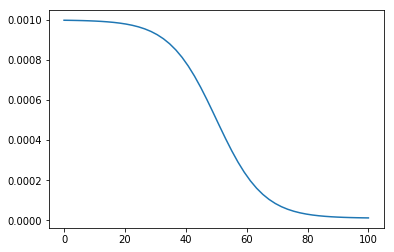

In [18]:
xs = np.linspace(0, 100)
ys = np.vectorize(sigmoidal_decay)(xs)
plt.plot(xs, ys)
plt.show()

In [21]:
EPOCHS = 12                        # !!! <------- Chnage to 30-100 for local evaluation

In [22]:
m = X_train.mean(axis=0)

X_train -= m
del m

In [23]:
m = X_train.mean(axis=0)
x_val -= m

In [24]:
X_test -= m

In [25]:
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=EPOCHS))

In [26]:
hist = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val), batch_size=512, callbacks=[lr, mc])

Train on 33600 samples, validate on 8400 samples
Epoch 1/12
33600/33600 [==============================] - 483s 14ms/step - loss: 3.1056 - acc: 0.3926 - val_loss: 2.8537 - val_acc: 0.1743
Epoch 2/12
33600/33600 [==============================] - 479s 14ms/step - loss: 1.5112 - acc: 0.8218 - val_loss: 2.8185 - val_acc: 0.1027
Epoch 3/12
33600/33600 [==============================] - 476s 14ms/step - loss: 1.0086 - acc: 0.9368 - val_loss: 2.8188 - val_acc: 0.0999
Epoch 4/12
33600/33600 [==============================] - 477s 14ms/step - loss: 0.8128 - acc: 0.9554 - val_loss: 2.7415 - val_acc: 0.0999
Epoch 5/12
33600/33600 [==============================] - 479s 14ms/step - loss: 0.7123 - acc: 0.9629 - val_loss: 2.5598 - val_acc: 0.1826
Epoch 6/12
33600/33600 [==============================] - 476s 14ms/step - loss: 0.6409 - acc: 0.9674 - val_loss: 2.4715 - val_acc: 0.1523
Epoch 7/12
33600/33600 [==============================] - 475s 14ms/step - loss: 0.5850 - acc: 0.9719 - val_loss: 2.3

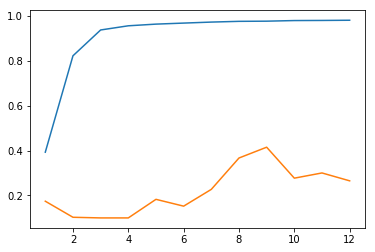

In [28]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
epochs = np.arange(1, EPOCHS + 1)

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.show()

In [29]:
model.load_weights('weights.best.keras')

In [30]:
p_test = model.predict(X_test, batch_size=512)
p_test = np.argmax(p_test, axis=1)

In [31]:
pd.DataFrame({'ImageId': 1 + np.arange(p_test.shape[0]), 'Label': p_test}).to_csv('output.csv', index=False)